In [1]:
import galsim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcess

In [2]:
aberration_amplitude = 0.15
n_ab = 8
n_lib = 200
aberrations = (np.random.uniform(size=(n_lib, n_ab)) - 0.5) * aberration_amplitude

PSFs = [galsim.OpticalPSF(lam=700, diam=8.4, obscuration=0.4, 
                          nstruts=4, strut_thick=0.03, 
                          aberrations=np.concatenate([[0]*4, a])) for a in aberrations]
PSFims = [PSF.drawImage(nx=32, ny=32, scale=0.005) for PSF in PSFs]

/Users/josh/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


/Users/josh/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


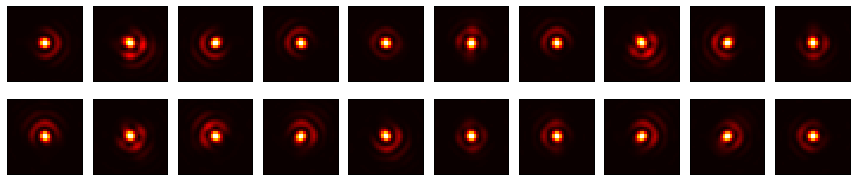

In [3]:
# Draw some PSFs
fig = plt.figure(figsize=(12,3))
for i in range(20):
    ax = fig.add_subplot(2,10,i+1)
    ax.imshow(PSFims[i].array)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.show()

In [4]:
# Format data for sklearn
Y = np.empty((n_lib, 32*32), dtype=float)
x = np.empty((n_lib, n_ab), dtype=float)
for i, (ab, im) in enumerate(zip(aberrations, PSFims)):
    Y[i] = im.array.flat / im.array.max()
    x[i] = ab

In [5]:
x_train, x_test, Y_train, Y_test = train_test_split(
    x, Y, test_size=0.25)

In [8]:
# PCA
n_components = 15
pca = PCA(n_components=n_components).fit(Y)
print np.cumsum(pca.explained_variance_ratio_)

[ 0.33583164  0.61505535  0.71286259  0.79698424  0.84921583  0.88646754
  0.91826024  0.93545885  0.94918174  0.96000305  0.96870375  0.97572724
  0.9817973   0.98582282  0.98933547]


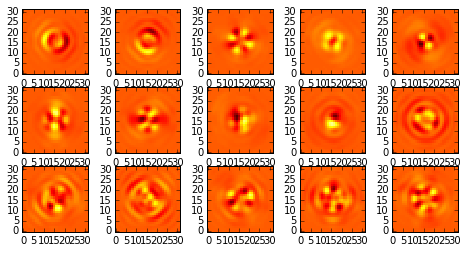

In [11]:
fig = plt.figure(figsize=(8,4))
for i, im in enumerate(pca.components_):
    im.shape = (32, 32)
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow(im, vmin=-0.3, vmax=0.3)

In [12]:
gp = GaussianProcess().fit(x_train, Y_train)
Y_gp = gp.predict(x_test)
gppca = GaussianProcess().fit(x_train, pca.transform(Y_train))
Y_gppca = pca.inverse_transform(gppca.predict(x_test))

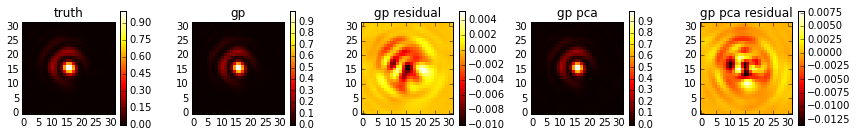

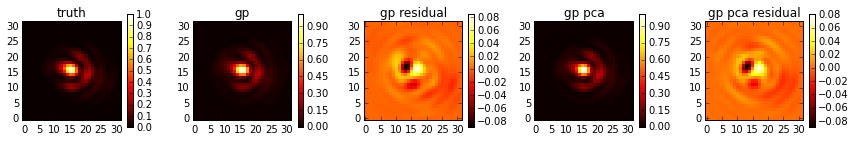

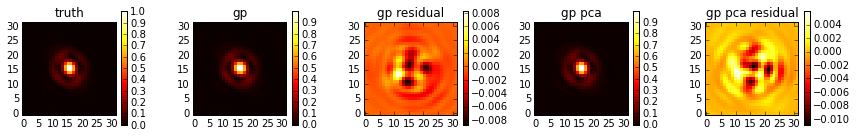

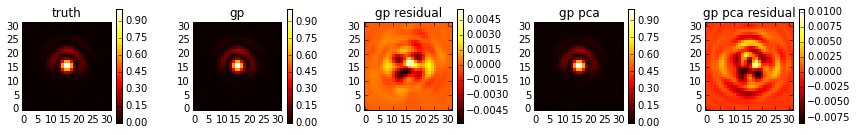

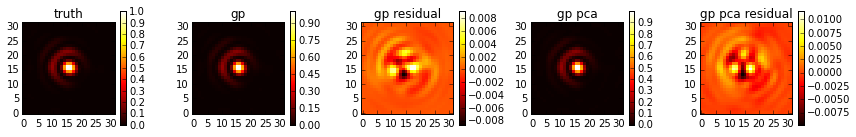

In [13]:
for Yt, Ygp, Ypca in zip(Y_test, Y_gp, Y_gppca)[0:5]:
    fig = plt.figure(figsize=(12,2))

    ax = fig.add_subplot(1,5,1)
    ax.set_title("truth")
    Yt = Yt.copy()
    Yt.shape = (32, 32)
    imt = ax.imshow(Yt)
    fig.colorbar(imt)

    ax = fig.add_subplot(1,5,2)
    ax.set_title("gp")
    Ygp = Ygp.copy()
    Ygp.shape = (32, 32)
    imgp = ax.imshow(Ygp)
    fig.colorbar(imgp)

    ax = fig.add_subplot(1,5,3)
    ax.set_title("gp residual")
    imres = ax.imshow(Ygp - Yt)
    fig.colorbar(imres)

    ax = fig.add_subplot(1,5,4)
    ax.set_title("gp pca")
    Ypca = Ypca.copy()
    Ypca.shape = (32, 32)
    impca = ax.imshow(Ypca)
    fig.colorbar(impca)

    ax = fig.add_subplot(1,5,5)
    ax.set_title("gp pca residual")
    imres2 = ax.imshow(Ypca - Yt)
    fig.colorbar(imres2)

    fig.tight_layout()

In [15]:
timeit Y_fit = gp.predict(x_test)

1000 loops, best of 3: 485 µs per loop


In [16]:
timeit Y_fit = pca.inverse_transform(gppca.predict(x_test))

1000 loops, best of 3: 387 µs per loop


In [17]:
def draw1():
    aberrations = (np.random.uniform(size=n_ab) - 0.5) * aberration_amplitude
    PSF = galsim.OpticalPSF(lam=700, diam=8.4, obscuration=0.4, 
                            nstruts=4, strut_thick=0.03, 
                            aberrations=np.concatenate([[0]*4, a]))
    PSFim = PSF.drawImage(nx=32, ny=32, scale=0.005)

In [18]:
timeit draw1()

1 loops, best of 3: 619 ms per loop
